In [1]:
import os
import sys
import json

In [2]:
def add_path(path):
    if path not in sys.path:
        sys.path.append(path)

In [3]:
project_dir = os.getcwd().split('Causality')[0] + 'Causality'
saved_models = os.getcwd().split('Causality')[0] + 'saved_models'
data_dir = os.getcwd().split('Causality')[0] + 'data'
add_path(project_dir)

In [4]:
from codebert.code.model import *
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)
from types import SimpleNamespace
import numpy as np
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
from torch.utils.data.distributed import DistributedSampler
import json

from tqdm import tqdm, trange

In [5]:
args = SimpleNamespace()
args.dropout_probability = 0

args.block_size=512
args.device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
config = RobertaConfig.from_pretrained('microsoft/codebert-base')
config.num_labels=1
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
model = RobertaForSequenceClassification.from_pretrained('microsoft/codebert-base', config=config)        

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be 

In [6]:
model = Model(model, config, args)

In [7]:
output_path = os.path.join(f"{saved_models}/codebert/Devign-checkpoint-best-f1/causality/seed_42/node_amp-1/causal_vanilla/tokenize_ast_tokens_0", 'model.bin')  
model.load_state_dict(torch.load(output_path))                  
model.to(args.device)

Model(
  (encoder): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear

In [8]:

class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 idx,
                 label,

    ):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.idx=str(idx)
        self.label=label

        
def convert_examples_to_features(js,tokenizer,args):
    code=' '.join(js['func'].split())
    # code=' '.join(js['func'].split())
    code_tokens=tokenizer.tokenize(code)[:args.block_size-2]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = args.block_size - len(source_ids)
    source_ids+=[tokenizer.pad_token_id]*padding_length
    return InputFeatures(source_tokens,source_ids,js['idx'],js['target'])

class TextDataset(Dataset):
    def __init__(self, tokenizer, args, file_path=None):
        self.examples = []
        with open(file_path) as f:
            for line in f:
                js=json.loads(line.strip())
                self.examples.append(convert_examples_to_features(js,tokenizer,args))
        if 'train' in file_path:
            for idx, example in enumerate(self.examples[:3]):
                    logger.info("*** Example ***")
                    logger.info("idx: {}".format(idx))
                    logger.info("label: {}".format(example.label))
                    logger.info("input_tokens: {}".format([x.replace('\u0120','_') for x in example.input_tokens]))
                    logger.info("input_ids: {}".format(' '.join(map(str, example.input_ids))))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):       
        return torch.tensor(self.examples[i].input_ids),torch.tensor(self.examples[i].label)
            

In [10]:
def test(args, model, tokenizer, test_data_file):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_dataset = TextDataset(tokenizer, args, test_data_file)
    args.eval_batch_size = 32
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset) 
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    model.eval()
    logits=[]   
    labels=[]
    representations = []
    for batch in tqdm(eval_dataloader,total=len(eval_dataloader)):
        inputs = batch[0].to(args.device)        
        label=batch[1].to(args.device) 
        with torch.no_grad():
            logit = model(inputs)
            logits.append(logit.cpu().numpy())
            labels.append(label.cpu().numpy())
            ## Get representation for TSNE plot
            representations.append(model.get_representation(inputs)[12][:, 0, :].cpu().numpy())

    logits=np.concatenate(logits,0)
    labels=np.concatenate(labels,0)
    representations=np.concatenate(representations, 0)
    # preds = np.argmax(logits, axis=1)
    preds=logits[:,0]>0.5
    
    return logits, preds, representations

In [11]:
def read_jsonl(data_path):
    f= open(data_path, 'r')
    data_ = [json.loads(ex) for ex in f]
    f.close()
    return data_

In [12]:
test_org = read_jsonl(f'{data_dir}/Devign/test.jsonl')
test_sp = read_jsonl(f'{data_dir}/Devign/test_spurious_v1.jsonl')

In [13]:
org_logits, org_preds, org_rp = test(args, model, tokenizer, f'{data_dir}/Devign/test.jsonl')
spur_logits, spur_preds, spur_rp = test(args, model, tokenizer, f'{data_dir}/Devign/test_spurious_v1.jsonl')


100%|██████████| 86/86 [00:47<00:00,  1.83it/s]


In [14]:
result_dir = f"{project_dir}/results/analysis"

In [16]:
f = open(f"{result_dir}/org_v1.json", 'w')
json.dump({'logits': org_logits.tolist(), 'preds': org_preds.tolist(), 'rp': org_rp.tolist()}, f)
f.close()

In [18]:
f = open(f"{result_dir}/spur_v1.json", 'w')
json.dump({'logits': spur_logits.tolist(), 'preds': spur_preds.tolist(), 'rp': spur_rp.tolist()}, f)
f.close()

In [19]:
cnt = 0
for i in range(len(test_org)):
    if test_org[i]['target'] == 0:
        continue
    if org_preds[i] == 0:
        continue
    
    length = len(test_org[i]['func'].split("\n"))
    if org_preds[i] != spur_preds[i] and length < 50:
        print(i, org_logits[i], spur_logits[i])
        print(test_org[i]['func'])

        print(test_sp[i]['func'])
        cnt += 1

23 [0.7455582] [0.36587325]
static av_cold int hevc_init_context(AVCodecContext *avctx)
{
    HEVCContext *s = avctx->priv_data;
    int i;
    s->avctx = avctx;
    s->HEVClc = av_mallocz(sizeof(HEVCLocalContext));
    if (!s->HEVClc)
        goto fail;
    s->HEVClcList[0] = s->HEVClc;
    s->sList[0] = s;
    s->cabac_state = av_malloc(HEVC_CONTEXTS);
    if (!s->cabac_state)
        goto fail;
    s->output_frame = av_frame_alloc();
    if (!s->output_frame)
        goto fail;
    for (i = 0; i < FF_ARRAY_ELEMS(s->DPB); i++) {
        s->DPB[i].frame = av_frame_alloc();
        if (!s->DPB[i].frame)
            goto fail;
        s->DPB[i].tf.f = s->DPB[i].frame;
    }
    s->max_ra = INT_MAX;
    s->md5_ctx = av_md5_alloc();
    if (!s->md5_ctx)
        goto fail;
    ff_bswapdsp_init(&s->bdsp);
    s->context_initialized = 1;
    s->eos = 0;
    return 0;
fail:
    hevc_decode_free(avctx);
    return AVERROR(ENOMEM);
}
static av_cold farg hevc_init_context ( AVCodecContext * tc0 

In [20]:
non_vul_rps = []
for i in range(len(test_org)):
    if test_org[i]['target'] == 0 and org_preds[i] == 0 and org_logits[i][0] < 0.20:
        non_vul_rps.append(org_rp[i])

In [21]:
non_vul_rps = non_vul_rps[:20]

In [22]:
vul_rps = []
for i in range(len(test_org)):
    if test_org[i]['target'] == 1 and org_preds[i] == 1 and org_logits[i][0] > 0.80:
        vul_rps.append(org_rp[i])

In [23]:
vul_rps = vul_rps[:20]

In [24]:
vul_rps.append(org_rp[116])

In [25]:
non_vul_rps.append(spur_rp[116])

In [26]:
len(vul_rps)

21

In [27]:
len(non_vul_rps)

21

In [28]:
X = vul_rps + non_vul_rps

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [30]:
pca = PCA(n_components=2)

In [31]:
X_pca = pca.fit_transform(X)

# import seaborn as sns
# sns.set()

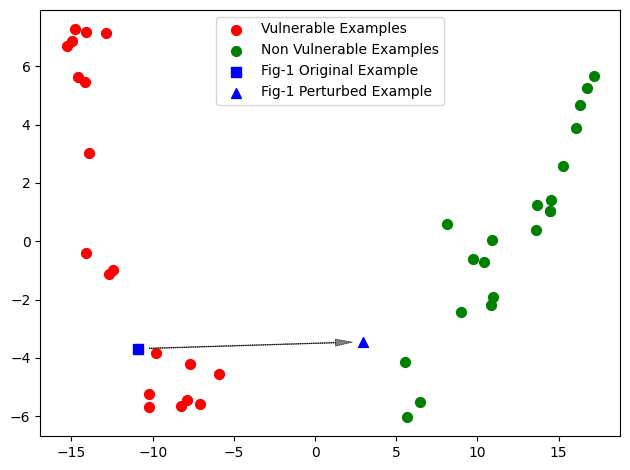

In [35]:
s=50
# plt.figure(figsize=(12, 6))
plt.gca().set_facecolor('white')

plt.scatter(X_pca[:20, 0], X_pca[:20, 1], c="red", s=s, marker='o', label='Vulnerable Examples')
plt.scatter(X_pca[21:41, 0], X_pca[21:41, 1], c="green",s=s, marker='o', label='Non Vulnerable Examples')
plt.scatter(X_pca[20:21, 0], X_pca[20:21, 1], c="blue", s=s,marker='s', label='Fig-1 Original Example ')
plt.scatter(X_pca[41:42, 0], X_pca[41:42, 1], c="blue",s=s, marker='^', label='Fig-1 Perturbed Example')

plt.annotate('', xy=X_pca[41], xytext=X_pca[20], 
            arrowprops=dict(facecolor='gray', shrink=0.05, width=0.5, headwidth=5, linestyle=':', lw=.5))
plt.legend()
plt.tight_layout()
plt.savefig("motivation_pca")